# Creating the state space

In [2]:
import numpy as np
import matplotlib.pyplot as plt
action_interval = 5

total_states = (360 / action_interval) * (360 / action_interval)
print(total_states)

5184.0


# Making the system

In [3]:
def getKey(state):
    return ','.join(str(v) for v in state)


class robot_arm:
    def __init__(self, goal_position, action_interval):
        self.total_states = (360/action_interval) * (360/action_interval)
        self.dtheta = action_interval
        self.value_table = {}
        self.policy = {}
        self.action_space = {0: (action_interval, action_interval), 1: (action_interval, -action_interval), 2: (-action_interval, action_interval), 3: (-action_interval, -action_interval), 4: (action_interval, 0), 5: (-action_interval, 0), 6: (0, action_interval), 7: (0, -action_interval)}
        self.obstacles = list()
        self.a1 = 0.5
        self.a2 = 0.5
        self.goal_states = []
        # self.current_state = self.initialize_state()
        # self.initialize_value_table(goal_position)
        self.goal_position = goal_position
        self.q_table = np.zeros
        self.terminal_states = list()

    def parse_state(self, statestr):
        return list(statestr.split(","))

    def get_reward_next_state(self, ac, current_state):
        cstate = self.parse_state(current_state)
        action = self.action_space[ac]
        q1 = action[0]
        q2 = action[1]
        new_q1 = int(cstate[0]) + q1
        new_q2 = int(cstate[1]) + q2

        new_q1 = new_q1 % 360
        new_q2 = new_q2 % 360
        
        T = self.get_T(new_q1, new_q2)
        x = T[0, 3]
        y = T[1, 3]
        new_state = [new_q1, new_q2, x, y]
        if getKey(new_state) in self.goal_states:
            reward = 1
        elif getKey(new_state) in self.terminal_states:
            reward = -1
        else:
            reward = 0

        return reward, new_state


    def initialize_value_table(self, goal_pos):
        for t1 in range(0, 361, self.dtheta):
            for t2 in range(0, 361, self.dtheta):
                T = self.get_T(t1, t2)
                state = [t1, t2, T[0, 3], T[1, 3]]
                position = [T[0, 3], T[1, 3]]

                dist = np.linalg.norm(np.array(goal_pos) - np.array(position))
                if dist < 0.1:
                    self.goal_states.append(getKey(state))
                else:
                    self.value_table[getKey(state)] = 0.0
                    self.policy[getKey(state)] = self.get_random_policy()

    def get_random_policy(self):
        return np.random.choice(list(self.action_space.keys()))

    def get_T(self, theta1, theta2):
        t1 = np.radians(theta1)
        t2 = np.radians(theta2)
        return np.array(
            [
                [np.cos(t1 + t2), -np.sin(t1 + t2), 0, self.a1*np.cos(t1) + self.a2*np.cos(t1 + t2)],
                [np.sin(t1 + t2), np.cos(t1 + t2), 0, self.a1 * np.sin(t1) + self.a2 * np.sin(t1 + t2)],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ]
        )
    
    def initialize_state(self):
        theta1 = 0
        theta2 = 0
        T = self.get_T(theta1, theta2)
        return [0, 0, T[0, 3], T[1, 3]]
    
    def plot_policy(self):
        plt.figure()
        plt.axis([-1.25, 1.25, -1.25, 1.25])
        for t1 in range(0, 361, self.dtheta):
            for t2 in range(0, 361, self.dtheta):
                T = self.get_T(t1, t2)
                state = [t1, t2, T[0, 3], T[1, 3]]
                if getKey(state) in self.goal_states:
                    continue
                else:
                    action = self.policy[getKey(state)]
                    if action == 0:
                        c = '#bf0000' #red 
                    elif action == 1:
                        c = '#bf4900' #orange
                    elif action == 2:
                        c = '#bfb900' #yellow
                    elif action == 3:
                        c = '#0dbf00' # green
                    elif action == 4:
                        c = "#0023bf" #blue
                    elif action == 5:
                        c = "#6b32fa" # purple
                    elif action == 6:
                        c = "#e300fc" #pink
                    elif action == 7:
                        c = "k"  #black

                    if T[0, 1] > 0:
                        plt.subplot(1, 2, 1)
                        plt.plot(T[0, 3], T[1, 3], color=c, marker="o")
                        plt.title('elbow down')
                    else:
                        plt.subplot(1, 2, 2)
                        plt.plot(T[0, 3], T[1, 3], color=c, marker="o")
                        plt.title('elbow up')

                    
                # plt.pause(0.05)
        plt.subplot(1, 2, 1)
        plt.plot(self.goal_position[0], self.goal_position[1], 'co')
        plt.subplot(1, 2, 2)
        plt.plot(self.goal_position[0], self.goal_position[1], 'co')
        plt.show()   

    def policy_evaluation(self, gamma = 1):
        for iteration in range(100):
            delta = 0
            all_states = list(self.value_table.keys())
            for state in all_states:
                if state in self.goal_states or state in self.terminal_states:
                    pass
                else:
                    v = self.value_table[state]
                    current_optimal_action = self.policy[state]
                    q = 0
                    reward, next_state = self.get_reward_next_state(current_optimal_action, state)
                    # self.current_state = next_state
                    q = reward + (gamma * self.value_table.get(getKey(next_state), 0))

                    self.value_table[state] = q
                    delta = max(delta, v - self.value_table[state])


    def policy_improvement(self, max_iterations=500, gamma=1):

        iteration = 0
        while True:
            policy_stable = True
            self.policy_evaluation(gamma)
            all_states = list(self.value_table.keys())
            for state in all_states:
                if state in self.goal_states or state in self.terminal_states:
                    continue
                else:
                    b = self.policy[state]
                    q = [0 for i in range(8)]
                    for action in list(self.action_space.keys()):
                        reward, next_state = self.get_reward_next_state(action, state)
                        q[action] = reward + (gamma * self.value_table.get(getKey(next_state), 0))

                    # print(q)
                    self.policy[state] = np.argmax(q)
                    if b != self.policy[state]:
                        policy_stable = False

            if policy_stable:
                return iteration
            else:
                iteration += 1
                        


test = robot_arm([0.5, 0.5], 5)
test.initialize_value_table(test.goal_position)
print(test.total_states)

5184.0


C:\Users\IbrahimSuhailArif\AppData\Local\Temp\ipykernel_6424\3124510903.py:118: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


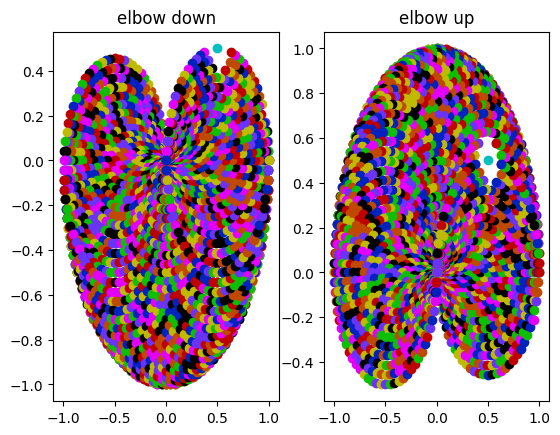

In [4]:
test.plot_policy()

In [5]:
test.policy_improvement(1000, 0.95)

31

C:\Users\IbrahimSuhailArif\AppData\Local\Temp\ipykernel_6424\3124510903.py:118: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


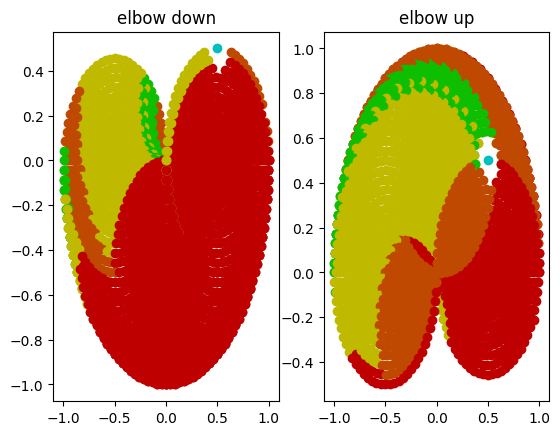

In [6]:
test.plot_policy()

In [7]:
test2 = robot_arm([-0.25, 0.5], 5)
test2.initialize_value_table([-0.25, 0.5])
test2.policy_improvement(gamma=0.85)

32

C:\Users\IbrahimSuhailArif\AppData\Local\Temp\ipykernel_6424\3124510903.py:118: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


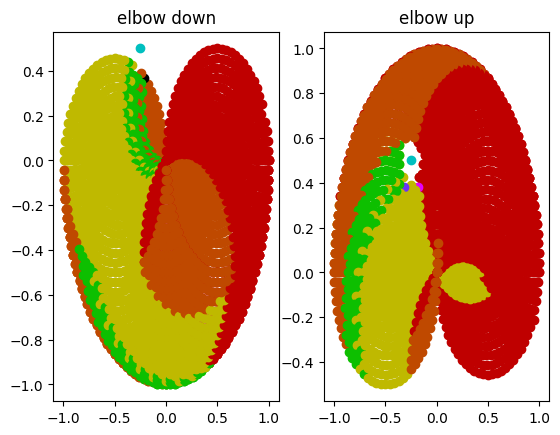

In [8]:
test2.plot_policy()

In [9]:
class obstacle:
    def __init__(self, center, length, obstacle_type):
        self.center = center
        self.length = length
        self.type = obstacle_type

    def check_collision(self, point):
        if self.type == "circle":
            temp = (point[0] - self.center[0]) ** 2 + (point[1] - self.center[1]) ** 2
            if temp <= (self.length ** 2):
                return True
            else:
                return False
            
        elif self.type == "square":
            temp = abs((point[0] - self.center[0]) + (point[1] - self.center[1])) + abs((point[0] - self.center[0]) - (point[1] - self.center[1]))
            if temp <= self.length:
                return True
            else:
                return False 

    

In [10]:
rect = obstacle((0.25, 0.25), 0.2, "square")
rect.check_collision((0.4, 0.2))

False

In [1]:
class robot_arm_with_obstacle(robot_arm):
    


    def add_obstacle(self, obstacletype, center, length):
        newObstacle = obstacle(center, length, obstacletype)
        self.obstacles.append(newObstacle)


    def initialize_value_table2(self, goal_pos):
        def detect_collision(th1, th2):
            a=0
            b=0
            flag = False
            for a in np.linspace(0, self.a1, 50, endpoint=True):
                x = a * np.cos(np.rad2deg(th1)) + b * np.cos(np.radians(th1 + th2))
                y = a * np.sin(np.radians(th1)) + b * np.cos(np.radians(th1 + th2))
                pt = (x, y)

                
                flag = rect.check_collision(pt)
                if flag:
                    return flag
            
            a = self.a1
            for b in np.linspace(0, self.a2, 50, endpoint=True):
                x = a * np.cos(np.radians(th1)) + b * np.cos(np.radians(th1 + th2))
                y = a * np.sin(np.radians(th1)) + b * np.sin(np.radians(th1 + th2))
                pt = (x, y)
                flag = rect.check_collision(pt)
                if flag:
                    return flag
                    
            return False

        for t1 in range(0, 361, self.dtheta):
            for t2 in range(0, 361, self.dtheta):
                T = self.get_T(t1, t2)
                state = [t1, t2, T[0, 3], T[1, 3]]
                position = [T[0,3], T[1, 3]]
                
                for obstacle in self.obstacles:
                    flag2 = obstacle.check_collision(position)
                    if flag2:
                        break
                
                if flag2:
                    self.terminal_states.append(getKey(state))
                    continue

                flag = detect_collision(t1, t2)
                

                if flag:
                    self.terminal_states.append(getKey(state))
                    continue
                
                dist = np.linalg.norm(np.array(goal_pos - np.array(position)))
                if dist < 0.1:
                    self.goal_states.append(getKey(state))
                    continue
                
                self.value_table[getKey(state)] = 0.0
                self.policy[getKey(state)] = self.get_random_policy()


    def plot_policy2(self):
        plt.figure()
        plt.axis([-1.25, 1.25, -1.25, 1.25])
        for t1 in range(0, 361, self.dtheta):
            for t2 in range(0, 361, self.dtheta):
                T = self.get_T(t1, t2)
                state = [t1, t2, T[0, 3], T[1, 3]]
                if getKey(state) in self.goal_states:
                    continue
                elif getKey(state) in self.terminal_states:
                    continue
                else:
                    action = self.policy[getKey(state)]
                    if action == 0:
                        c = '#bf0000' #red 
                    elif action == 1:
                        c = '#bf4900' #orange
                    elif action == 2:
                        c = '#bfb900' #yellow
                    elif action == 3:
                        c = '#0dbf00' # green
                    elif action == 4:
                        c = "#0023bf" #blue
                    elif action == 5:
                        c = "#6b32fa" # purple
                    elif action == 6:
                        c = "#e300fc" #pink
                    elif action == 7:
                        c = "k"  #black
                    
                    if T[0, 1] > 0:
                        plt.subplot(1, 2, 1)
                        plt.plot(T[0, 3], T[1, 3], color=c, marker="o")
                        plt.title('elbow down')
                    else:
                        plt.subplot(1, 2, 2)
                        plt.plot(T[0, 3], T[1, 3], color=c, marker="o")
                        plt.title('elbow up')

                    
                # plt.pause(0.05)
        plt.subplot(1, 2, 1)
        plt.plot(self.goal_position[0], self.goal_position[1], 'co')
        plt.subplot(1, 2, 2)
        plt.plot(self.goal_position[0], self.goal_position[1], 'co')
        plt.show()   


NameError: name 'robot_arm' is not defined

In [309]:
env = robot_arm_with_obstacle([0.5, 0.5], 5)
env.add_obstacle("square", (0.25, 0.25), 0.1)
env.initialize_value_table2(env.goal_position)

C:\Users\IbrahimSuhailArif\AppData\Local\Temp\ipykernel_29680\979785066.py:98: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


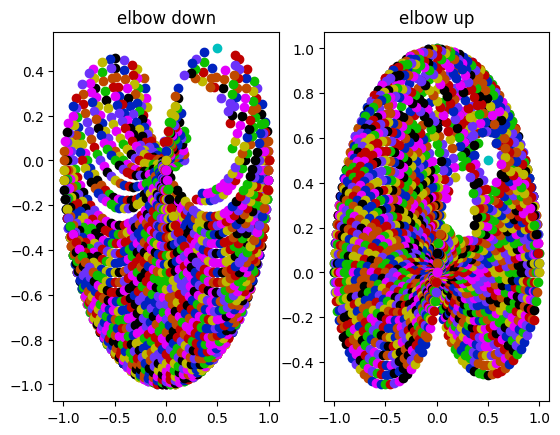

In [310]:
env.plot_policy2()

In [311]:
env.policy_improvement(gamma=0.85)

54

C:\Users\IbrahimSuhailArif\AppData\Local\Temp\ipykernel_29680\979785066.py:98: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


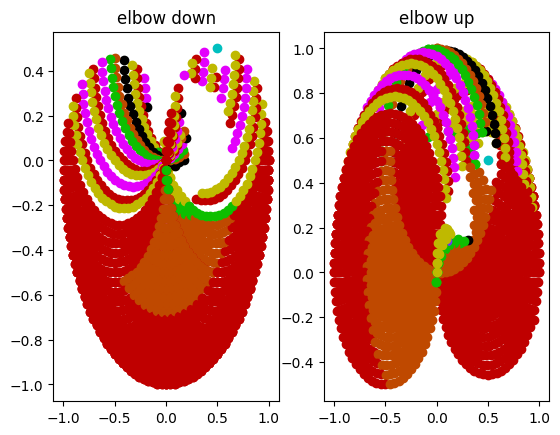

In [312]:
env.plot_policy2()